# Main code

In [29]:
# Import required libraries
from abc import ABC, abstractmethod
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers, utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [30]:
# Interface for MNIST classifiers
class MnistClassifierInterface(ABC):
    @abstractmethod
    def train(self):
        pass

    @abstractmethod
    def predict(self, X):
        pass

# Implementation for Random Forest
class MnistRFClassifier(MnistClassifierInterface):
    def __init__(self):
        # Load data
        (self.X_train, self.y_train), (self.X_test, self.y_test) = mnist.load_data()
        # Reshape 28x28 images into 1D arrays (784 features)
        self.X_train = self.X_train.reshape(self.X_train.shape[0], -1)
        self.X_test = self.X_test.reshape(self.X_test.shape[0], -1)
        # Normalize pixel values (divide by 255)
        self.X_train = self.X_train / 255.0
        self.X_test = self.X_test / 255.0
        self.model = None

    def train(self):
        # Set the pre-determined best parameters
        self.model = RandomForestClassifier(
            n_estimators=200,
            min_samples_leaf=1,
            min_samples_split=2,
            random_state=42,
            n_jobs=-1
        )
        self.model.fit(self.X_train, self.y_train)

        # Evaluate the model on the test set
        y_pred = self.model.predict(self.X_test)
        accuracy = accuracy_score(self.y_test, y_pred)
        print(f"Test Accuracy: {accuracy:.4f}")
        print("\nClassification Report:\n", classification_report(self.y_test, y_pred))

        # Identify indices of misclassified samples
        misclassified_idx = np.where(self.y_test != y_pred)[0]
        misclassified_dict = {}
        for idx in misclassified_idx:
            true_label = self.y_test[idx]
            pred_label = y_pred[idx]
            if true_label not in misclassified_dict:
                misclassified_dict[true_label] = []
            misclassified_dict[true_label].append((idx, pred_label))
        sorted_misclassified = sorted(misclassified_dict.items(), key=lambda x: len(x[1]))
        total_misclassified = 0
        for true_label, errors in sorted_misclassified:
            print(f"Class {true_label}: misclassified {len(errors)} examples")
            total_misclassified += len(errors)
        print(f"Total misclassified samples: {total_misclassified}")

    def predict(self, X):
        # Ensure the input data has the correct shape (28x28 -> 784)
        if X.ndim == 3:  # If X has shape (num_samples, 28, 28)
            X = X.reshape(X.shape[0], -1)

        # Normalize pixel values to the range [0,1]
        X = X / 255.0

        predictions = self.model.predict(X)
    
        # Display predictions in a readable format
        print("Predicted Labels:")
        print(", ".join(map(str, predictions)))
    
        return predictions 

# Placeholder for NN (methods are left empty as data processing may differ)
class MnistNNClassifier(MnistClassifierInterface):
    def __init__(self):
        # Load data
        (self.X_train, self.y_train), (self.X_test, self.y_test) = mnist.load_data()
        # Normalize pixel values
        # Note: Here we do not reshape to (28,28,1) yet, because for augmentation and model training we will work with flattened images.
        self.X_train = self.X_train / 255.0
        self.X_test = self.X_test / 255.0
        self.model = None

    def train(self):
        # Preprocess: Flatten images into 1D vectors
        x_train = self.X_train.reshape(-1, 28 * 28)
        x_test = self.X_test.reshape(-1, 28 * 28)
        
        # Select classes (all digits in a specified order)
        selected_classes = [5, 8, 9, 1, 2, 3, 4, 6, 7, 0]
        indices = np.where(np.isin(self.y_train, selected_classes))[0]
        x_selected = x_train[indices]   # Selected images
        y_selected = self.y_train[indices]  # Corresponding labels

        # Expand selected images to 28x28x1 (for augmentation)
        x_selected = x_selected.reshape(-1, 28, 28, 1)

        # Configure the generator for augmentation
        datagen = ImageDataGenerator(
            rotation_range=15,       # Random rotation
            width_shift_range=0.1,   # Horizontal shift
            height_shift_range=0.1,  # Vertical shift
            zoom_range=0.1,          # Scaling
            shear_range=0.1,         # Shearing
            fill_mode='nearest'      # Pixel filling after transformation
        )

        # Generate augmented images
        augmented_images = []
        augmented_labels = []
        num_augmented = len(x_selected)  # Number of images to augment

        for i in range(num_augmented):
            img = x_selected[i]
            img = np.expand_dims(img, axis=0)  # Add batch dimension
            it = datagen.flow(img, batch_size=1)
            # Create 3 augmented copies for each image
            for _ in range(3):
                augmented_img = next(it)[0]
                augmented_images.append(augmented_img)
                augmented_labels.append(y_selected[i])

        # Convert augmented data to arrays
        augmented_images = np.array(augmented_images)
        augmented_labels = np.array(augmented_labels)

        # Since x_train is flattened, reshape augmented images accordingly
        augmented_images_flat = augmented_images.reshape(-1, 28 * 28)
        x_train = np.concatenate((x_train, augmented_images_flat))
        y_train = np.concatenate((self.y_train, augmented_labels))

        # Build Feed-Forward Neural Network
        model = keras.Sequential([
            layers.Input(shape=(28 * 28,)),
            layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
            layers.Dropout(0.1),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.1),
            layers.Dense(64, activation='relu'),
            layers.Dense(10, activation='softmax')
        ])

        # Configure learning rate schedule and optimizer
        initial_learning_rate = 0.001
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate, decay_steps=1000, decay_rate=0.9, staircase=True)
        optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

        model.compile(optimizer=optimizer,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

        # Train the model
        history = model.fit(x_train, y_train, epochs=15, batch_size=64,
                            validation_data=(x_test, self.y_test))

        # Plot training and validation accuracy and loss
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Evaluate the model on the test set
        y_pred_probs = model.predict(x_test)
        y_pred = np.argmax(y_pred_probs, axis=1)
        print(classification_report(self.y_test, y_pred))

        # Identify misclassified samples
        misclassified_idx = np.where(self.y_test != y_pred)[0]
        misclassified_dict = {}
        for idx in misclassified_idx:
            true_label = self.y_test[idx]
            pred_label = y_pred[idx]
            if true_label not in misclassified_dict:
                misclassified_dict[true_label] = []
            misclassified_dict[true_label].append((idx, pred_label))
        sorted_misclassified = sorted(misclassified_dict.items(), key=lambda x: len(x[1]))
        total_errors = 0
        for true_label, errors in sorted_misclassified:
            print(f"Class {true_label}: {len(errors)} misclassified samples")
            total_errors += len(errors)
        print(f"Total misclassified samples: {total_errors}")

        # Construct the confusion matrix
        y_pred = model.predict(x_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        cm = confusion_matrix(self.y_test, y_pred_classes)

        # Visualize the confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=np.arange(10), yticklabels=np.arange(10))
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()

        self.model = model  # Save the trained model

    def predict(self, X):
        # Ensure the input data has the correct shape (28x28 -> 784)
        if X.ndim == 3:  # If X has shape (num_samples, 28, 28)
            X = X.reshape(X.shape[0], 28 * 28).astype('float32') / 255.0
        elif X.ndim == 2:  # If a single image (28x28) is passed
            X = X.reshape(1, 28 * 28).astype('float32') / 255.0
    
        # Make predictions (returns probabilities)
        y_pred_probs = self.model.predict(X)
    
        # Convert probabilities to class labels
        y_pred_classes = np.argmax(y_pred_probs, axis=1)
    
        # Display formatted output
        print("Predicted Labels:", ", ".join(map(str, y_pred_classes)))
    
        return y_pred_classes


# Placeholder for CNN (methods are left empty as data processing may differ)
class MnistCNNClassifier(MnistClassifierInterface):
    def __init__(self):
        # Load data
        (self.X_train, self.y_train), (self.X_test, self.y_test) = mnist.load_data()
        
        # Normalize pixel values to be between 0 and 1 and reshape for CNN
        self.X_train = self.X_train.reshape((-1, 28, 28, 1)).astype('float32') / 255.0
        self.X_test = self.X_test.reshape((-1, 28, 28, 1)).astype('float32') / 255.0

        # One-hot encode the labels
        self.y_train = to_categorical(self.y_train, num_classes=10)
        self.y_test = to_categorical(self.y_test, num_classes=10)
        
        self.model = None

    def train(self):
        # Define the CNN model exactly as provided
        self.model = models.Sequential([
            layers.Input(shape=(28, 28, 1)),

            # First convolutional block
            layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            # Second convolutional block
            layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            # Fully connected layers
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.25),
            layers.Dense(10, activation='softmax')
        ])

        # Compile the model
        self.model.compile(optimizer='adam',
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

        # Print the model summary
        #self.model.summary()

        # Train the model
        history = self.model.fit(self.X_train, self.y_train, epochs=10, batch_size=64,
                                 validation_data=(self.X_test, self.y_test))

        # Evaluate the model
        test_loss, test_acc = self.model.evaluate(self.X_test, self.y_test)
        print(f'Test accuracy: {test_acc:.4f}')

        # --- Evaluation Code ---
        # Make predictions on the test set
        y_pred_probs = self.model.predict(self.X_test)  # Get probability outputs
        y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convert to class labels
        y_true = np.argmax(self.y_test, axis=1)  # Convert one-hot labels to class indices

        # Find indices of misclassified samples
        misclassified_idx = np.where(y_true != y_pred_classes)[0]

        # Create a dictionary to store misclassified examples
        misclassified_dict = {}
        for idx in misclassified_idx:
            true_label, pred_label = y_true[idx], y_pred_classes[idx]
            misclassified_dict.setdefault(true_label, []).append((idx, pred_label))

        # Sort misclassified classes by the number of misclassifications
        sorted_misclassified = sorted(misclassified_dict.items(), key=lambda x: len(x[1]))

        # Display misclassification statistics
        total_errors = sum(len(errors) for _, errors in sorted_misclassified)
        print("Misclassification Summary:")
        for true_label, errors in sorted_misclassified:
            print(f"Class {true_label}: {len(errors)} misclassified samples")
        print(f"Total misclassified samples: {total_errors}")

        # Construct and visualize the confusion matrix
        cm = confusion_matrix(y_true, y_pred_classes)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=np.arange(10), yticklabels=np.arange(10))
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()


    def predict(self, X):
        # Ensure the input data has the correct shape (28x28 -> 28x28x1)
        if X.ndim == 3:  # If X has shape (num_samples, 28, 28)
            X = X.reshape((-1, 28, 28, 1)).astype('float32') / 255.0
        elif X.ndim == 2:  # If a single image (28x28) is passed
            X = X.reshape((1, 28, 28, 1)).astype('float32') / 255.0
    
        # Make predictions (returns probabilities)
        y_pred_probs = self.model.predict(X)
    
        # Convert probabilities to class labels
        y_pred_classes = np.argmax(y_pred_probs, axis=1)
    
        # Display formatted output
        print("Predicted Labels:", ", ".join(map(str, y_pred_classes)))
    
        return y_pred_classes

# Wrapper class that takes the algorithm name and uses the corresponding model
class MnistClassifier:
    def __init__(self, algorithm):
        self.algorithm = algorithm.lower()
        if self.algorithm == 'rf':
            self.model = MnistRFClassifier()
        elif self.algorithm == 'cnn':
            self.model = MnistCNNClassifier()
        elif self.algorithm == 'nn':
            self.model = MnistNNClassifier()
        else:
            raise ValueError("Invalid algorithm. Choose from 'cnn', 'rf', or 'nn'.")

    def train(self):
        self.model.train()

    def predict(self, X):
        return self.model.predict(X)




# Examples for prediction

Loads the MNIST dataset and selects a random subset of test images.  
Displays the selected images along with their true labels in a grid format.

In [19]:
def select_random_images(num_samples=5):
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
    indices = np.random.choice(len(x_test), 5, replace=False)
    return x_test[indices], y_test[indices]

def predict_and_display(images, labels):
    fig, axes = plt.subplots(1, 5, figsize=(10, 2))
    for i, ax in enumerate(axes):
        ax.imshow(images[i].squeeze(), cmap="gray")
        ax.set_title(f"Label: {labels[i]}")
        ax.axis("off")
    plt.show()


# Edge Case

This test case verifies that the MnistClassifier correctly handles an invalid algorithm input by raising a ValueError.  
The error message confirms that the classifier restricts the algorithm choices to 'cnn', 'rf', or 'nn', ensuring robust input validation.

In [14]:
classifier = MnistClassifier("wrong_algorithm")

ValueError: Invalid algorithm. Choose from 'cnn', 'rf', or 'nn'.

# Random Forest

The training analysis of a Random Forest model includes key performance metrics and misclassification insights:  
	•	Test Accuracy: Provides an overall measure of the model’s correctness on unseen data.  
	•	Classification Report: Displays precision, recall, and F1-score for each class, offering a detailed evaluation of the model’s ability to correctly classify different categories.  
	•	Misclassification Summary: Highlights the number of incorrectly classified samples per class, helping to identify patterns in errors and areas for potential improvement.  

This analysis aids in assessing the model’s strengths and weaknesses, guiding further optimization and refinement.  

In [3]:
# Create a classifier using the Random Forest algorithm
mnist_classifier = MnistClassifier('rf')
mnist_classifier.train()


Test Accuracy: 0.9692

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.96      1032
           3       0.96      0.97      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.97      0.96      0.96       892
           6       0.98      0.98      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.96      0.95      0.96       974
           9       0.96      0.95      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Class 0: misclassified 9 examples
Class 1: misclassified 11 examples
Class 6: misclassified 22 examples
Class 4: misclassified 28 examples
Class 2: misclassified 32 examples
Class 3: misclassifi

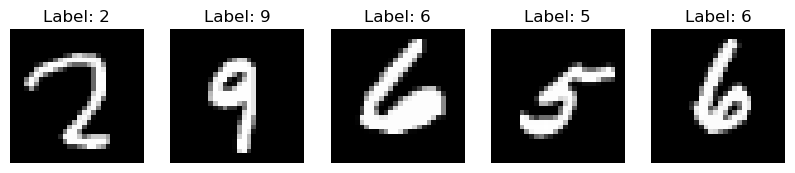

Predicted Labels:
2, 9, 6, 5, 6


In [13]:
images, labels = select_random_images()
predict_and_display(images, labels)
predictions = mnist_classifier.predict(images)

# Feed-Forward Neural Network

The training analysis of a Feed-Forward Neural Network (FFNN) includes detailed insights into the model’s performance across multiple epochs:  
	•	Epoch-wise Training Progress: Displays loss and accuracy at each epoch, showing how the model improves over time.  
	•	Training History Visualization: A graphical representation of loss and accuracy curves, helping to identify trends such as convergence, overfitting, or underfitting.  
	•	Classification Report: Summarizes precision, recall, and F1-score for each class, providing a detailed evaluation of the model’s classification performance.  
	•	Confusion Matrix: Offers a visual representation of correct and incorrect predictions, helping to analyze which classes are frequently misclassified.  

This analysis provides a comprehensive understanding of the model’s learning behavior, guiding further improvements through hyperparameter tuning or architectural modifications.

Epoch 1/15
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - accuracy: 0.8408 - loss: 0.6800 - val_accuracy: 0.9772 - val_loss: 0.1736
Epoch 2/15
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.9481 - loss: 0.2661 - val_accuracy: 0.9819 - val_loss: 0.1362
Epoch 3/15
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.9602 - loss: 0.2022 - val_accuracy: 0.9850 - val_loss: 0.1072
Epoch 4/15
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.9672 - loss: 0.1649 - val_accuracy: 0.9874 - val_loss: 0.0950
Epoch 5/15
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - accuracy: 0.9730 - loss: 0.1362 - val_accuracy: 0.9887 - val_loss: 0.0796
Epoch 6/15
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.9773 - loss: 0.1162 - val_accuracy: 0.9890 - val_loss: 0.0747
Epoch 7/15
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.9810 - loss: 0.1018 - val_accuracy: 0.9894 - val_loss: 0.0669
Epoch 8/15
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.9816 - loss: 0

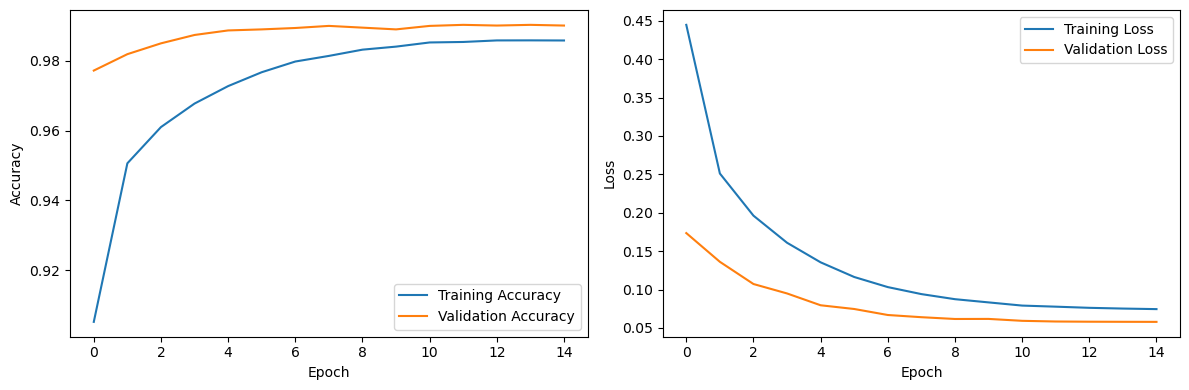

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.99      0.98      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

Class 1: 3 misclassified samples
Class 0: 5 misclassified samples
Class 3: 8 misclassified samples
Class 2: 8 misclassified samples
Class 6: 9 misclassified samples
Class 4: 9 misclassified samples


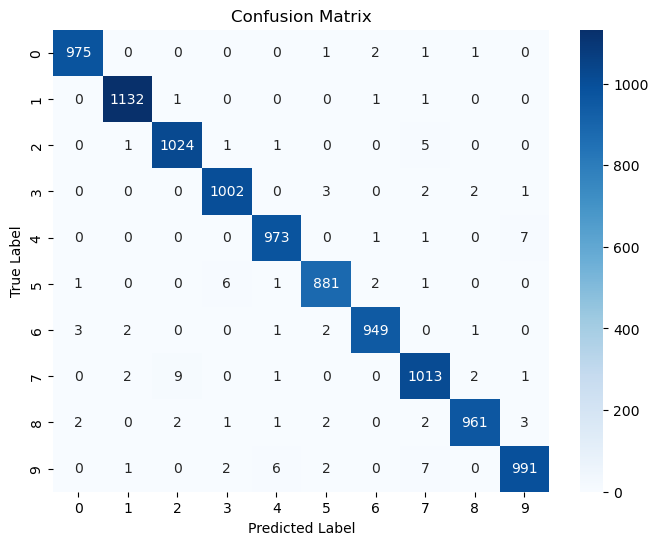

In [33]:
# Create a classifier using the Random Forest algorithm
mnist_classifier = MnistClassifier('nn')
mnist_classifier.train()


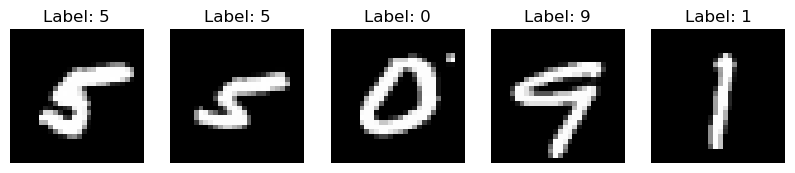

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
Predicted Labels: 5, 5, 0, 9, 1


In [25]:
images, labels = select_random_images()
predict_and_display(images, labels)
predictions = mnist_classifier.predict(images)

# Convolutional Neural Network

The training analysis of a Convolutional Neural Network (CNN) includes key performance metrics to evaluate its learning process and classification effectiveness:  
	•	Epoch-wise Training Progress: Displays loss and accuracy at each epoch, tracking how the model improves over time and detecting potential overfitting or underfitting.  
	•	Misclassification Summary: Provides insights into incorrectly classified samples per class, helping to identify patterns in errors and challenging categories.  
	•	Confusion Matrix: A visual representation of true vs. predicted labels, allowing for a deeper analysis of the model’s strengths and weaknesses in classifying different categories.  

This comprehensive evaluation helps assess the CNN’s effectiveness and guides potential improvements through architectural adjustments, data augmentation, or hyperparameter tuning.

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 37s 35ms/step - accuracy: 0.9098 - loss: 0.2896 - val_accuracy: 0.9884 - val_loss: 0.0317
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 36s 39ms/step - accuracy: 0.9831 - loss: 0.0525 - val_accuracy: 0.9839 - val_loss: 0.0482
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 36s 38ms/step - accuracy: 0.9881 - loss: 0.0390 - val_accuracy: 0.9910 - val_loss: 0.0258
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 35s 37ms/step - accuracy: 0.9901 - loss: 0.0313 - val_accuracy: 0.9920 - val_loss: 0.0240
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 37s 39ms/step - accuracy: 0.9917 - loss: 0.0257 - val_accuracy: 0.9915 - val_loss: 0.0256
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 35s 37ms/step - accuracy: 0.9920 - loss: 0.0258 - val_accuracy: 0.9903 - val_loss: 0.0271
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 36s 38ms/step - accuracy: 0.9937 - loss: 0.0206 - val_accuracy: 0.9934 - val_loss: 0.0217
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 35s 37ms/step - accuracy: 0.9936 - loss: 0.0203 - 

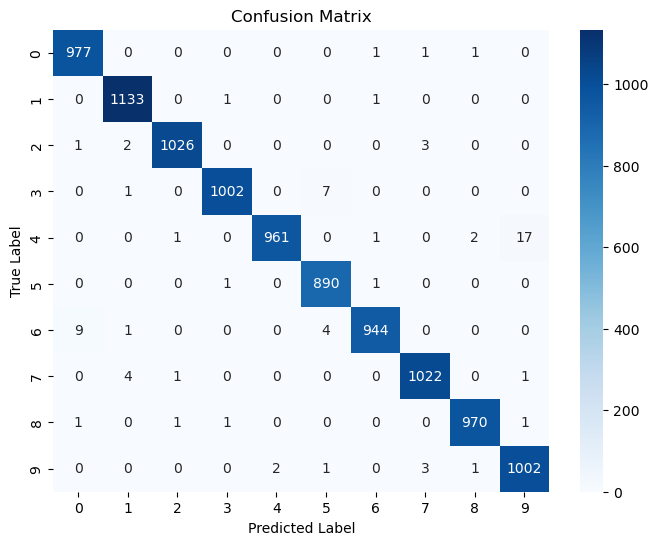

In [31]:
# Create a classifier using the Random Forest algorithm
mnist_classifier = MnistClassifier('cnn')
mnist_classifier.train()


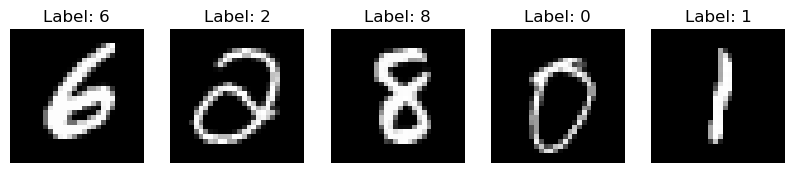

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
Predicted Labels: 6, 2, 8, 0, 1


In [32]:
images, labels = select_random_images()
predict_and_display(images, labels)
predictions = mnist_classifier.predict(images)